In [1]:
#setup
import numpy as np
import pandas as pd
from PIL import Image
from IPython.display import display

from sklearn.decomposition import PCA
from scipy.spatial import distance_matrix as dist_
from scipy.stats import mode as mode
from sklearn.metrics.pairwise import euclidean_distances as euclidean_distance


import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix




In [2]:
def draw_face(img):
    img = img.reshape(60, 82).T
    display(Image.fromarray(img))

In [3]:
data_train = pd.read_csv('ri_train.csv',header=None).astype(np.float64).T.values
data_train.shape
data_test = pd.read_csv('ri_test.csv',header=None).astype(np.float64).T.values

In [4]:
def dist(point,matrix):
    return np.sqrt(np.sum(((point-matrix)**2),axis=1))

In [5]:

def nearest(img,data_train,diff_dist):
    d = dist(img,data_train)
    nearest_ = np.argmin(d)
    if d[nearest_] <= diff_dist:
        nearest_ = nearest_ // 5
        return nearest_
    return None
    

In [6]:
def calculate_accuracy(data_train,data_test,diff_dist):
    
    preds_train = []
    for d in data_train:
        preds_train.append(nearest(d,data_train,diff_dist))

    
    preds_test = []
    for d in data_test:
        preds_test.append(nearest(d,data_train,diff_dist))
    
    COUNTER = 0
    for i in range(len(data_train)):
        if preds_train[i] == i//5:
            COUNTER += 1
    print(f'Accuracy for train data: {COUNTER / len(data_train) * 100}')

    COUNTER = 0
    NONE = 0
   
    for j in range(len(data_test)):
        if preds_test[j] == j//2 :
            COUNTER += 1
        if preds_test[j] == None:
            NONE += 1
    print(f'Accuracy for test data: {COUNTER / len(data_test) * 100}') 
    print(f'Failed to identify : {NONE} faces')


# Task 3 - getting preds and testing accuracy for test photos

In [7]:
data_train.shape

(250, 4920)

In [8]:
calculate_accuracy(data_train,data_test,5000)


Accuracy for train data: 100.0
Accuracy for test data: 17.0
Failed to identify : 0 faces


# Task 4 - testing accuracy for faces with reduced dimensionality
more dimensions -> greater accuracy, reducing dimensions causes the need to change the epsilon for distance 

In [9]:
def KNN(train_x,test_y,train_labels,K):
    closer = np.argpartition(dist_(test_y,train_x),K)
    targets = train_labels[closer]
    labels= targets[:,:K]
    targets = mode(labels, axis=1)[0]
    
    return targets.ravel()

def accuracy(predictions,targets):
    result=(list(predictions==targets))
    err = len(result) - result.count(True)
    accuracy = result.count(True)/len(result) 
    return accuracy

def crossvalidation(X,labels):
    indices = np.random.uniform(0, 10, len(X)).astype(int)
    sum = {}
    Ks = np.arange(1,20,3)
    for j,k in enumerate(Ks):
        for i in range(10):
            X_test = X[indices == i]
            X_labels = labels[indices == i]
            Y_train = X[indices != i]
            Y_labels = labels[indices != i]
            new_targets = KNN(Y_train,X_test,Y_labels,k)
            if i==0:
                sum[k] = accuracy(new_targets,X_labels) / 10
            else:
                sum[k] += accuracy(new_targets,X_labels) /10
    return sum



In [10]:
pca = PCA(80,whiten=True)
data_train_reduced = pca.fit_transform(data_train)
data_test_reduced = pca.transform(data_test)
calculate_accuracy(data_train_reduced,data_test_reduced,500)


Accuracy for train data: 100.0
Accuracy for test data: 94.0
Failed to identify : 0 faces


In [11]:
data_train_reduced.shape

(250, 80)

# Task 5

In [12]:
def KNN(train_x,test_y,train_labels,K):
    closer = np.argpartition(dist_(test_y,train_x),K)
    targets = train_labels[closer]
    labels= targets[:,:K]
    targets = mode(labels, axis=1)[0]
    
    return targets.ravel()

def accuracy(predictions,targets):
    result=(list(predictions==targets))
    err = len(result) - result.count(True)
    accuracy = result.count(True)/len(result) * 100
    return accuracy

def crossvalidation(X,labels):
    indices = np.random.uniform(0, 10, len(X)).astype(int)
    sum = {}
    Ks = np.arange(1,20,3)
    for j,k in enumerate(Ks):
        for i in range(10):
            X_test = X[indices == i]
            X_labels = labels[indices == i]
            Y_train = X[indices != i]
            Y_labels = labels[indices != i]
            new_targets = KNN(Y_train,X_test,Y_labels,k)
            if i==0:
                sum[k] = accuracy(new_targets,X_labels) / 10
            else:
                sum[k] += accuracy(new_targets,X_labels) /10
    return sum

In [13]:
combined_data = np.concatenate((data_train, data_test))
combined_labels = np.concatenate(([i//5 for i in range(len(data_train))], [i//2 for i in range(len(data_test))]))

In [14]:
def crossvalidation_for_pca(X,labels,dimensions):
    indices = np.random.uniform(0, 10, len(X)).astype(int)
    dict_ = {}
    Ks = np.arange(1,20,3)
    for dim in dimensions:
        pca = PCA(dim,whiten=True)
        for j,k in enumerate(Ks):
            for i in range(10):
                X_test = X[indices == i]
                X_labels = labels[indices == i]
                Y_train = X[indices != i]
                Y_labels = labels[indices != i]
                Y_train = pca.fit_transform(Y_train)
                X_test = pca.transform(X_test)
                new_targets = KNN(Y_train,X_test,Y_labels,k)
                if i>0:
                    dict_[(dim,k)] += accuracy(new_targets,X_labels)/10
                else:
                    dict_[(dim,k)] = accuracy(new_targets,X_labels)/10
    return dict_
dimensions = [10,45,70,105,140] 

In [15]:
pca_dict = crossvalidation_for_pca(combined_data,combined_labels,dimensions)

In [16]:
pca_dict_2 = crossvalidation_for_pca(combined_data,combined_labels,[175,210,245,280,300])

In [17]:
normal_dict = crossvalidation(combined_data,combined_labels)

In [18]:
for k,v in pca_dict_2.items():
    pca_dict[k]=v

In [19]:
pca_dict

{(10, 1): 44.327250983527264,
 (10, 4): 42.846528654807976,
 (10, 7): 41.66762304488335,
 (10, 10): 39.37891108277431,
 (10, 13): 41.96384934739891,
 (10, 16): 41.829806074917514,
 (10, 19): 40.508492204541774,
 (45, 1): 88.14653728315419,
 (45, 4): 85.56426796150302,
 (45, 7): 84.62212871336023,
 (45, 10): 81.21259314038095,
 (45, 13): 80.68130145407454,
 (45, 16): 77.33486539145645,
 (45, 19): 73.47159212717887,
 (70, 1): 88.74858563306282,
 (70, 4): 84.9122432630942,
 (70, 7): 84.2100180015074,
 (70, 10): 79.738351947818,
 (70, 13): 78.88434734863085,
 (70, 16): 76.34562309752782,
 (70, 19): 75.0134708441182,
 (105, 1): 86.98549979123435,
 (105, 4): 80.62460320707179,
 (105, 7): 79.16234107669075,
 (105, 10): 77.10263924098462,
 (105, 13): 73.76489230129523,
 (105, 16): 70.95918022057758,
 (105, 19): 64.75480227835457,
 (140, 1): 82.9915430201323,
 (140, 4): 72.5305028348274,
 (140, 7): 67.8699736655353,
 (140, 10): 63.83757637751355,
 (140, 13): 61.745314472751645,
 (140, 16): 57.4

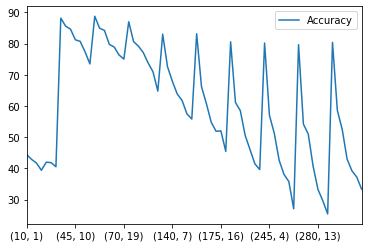

In [20]:
pca_df = pd.DataFrame.from_dict(pca_dict,orient='index',columns=['Accuracy'])
pca_df.plot()

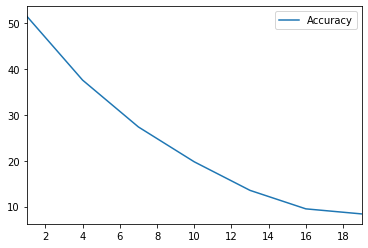

In [21]:
normal_df = pd.DataFrame.from_dict(normal_dict,orient='index',columns=['Accuracy'])
normal_df.plot()